    A Minimalist Computation Graph Framework 
https://github.com/davidrosenberg/mlcourse/blob/gh-pages/Notebooks/computation-graph/computation-graph-framework.ipynb

In [1]:
import numpy as np
from IPython.display import Image

We start with a completely trival example by making a computation graph with a single node,  representing a scalar value $x$. To represent $x$, we'll use a node called a "value node", since it takes no input, but its output is the value of $x$.  Later, in machine learning contexts, we'll use nodes of this type to represent inputs, outcomes, and parameters.

We will interpret this single-node computation graph as representing the function $f(x)=x$.  Thus the "graph output", i.e the scalar-valued output of the function our computation graph represents, is also the scalar $x$.  We will refer to the node whose output is the graph output as the "graph output node".  Our computation graphs are only designed to represent scalar-valued functions, since our goal is to find inputs that minimize of maximize the function, and it's not clear what that means for a vector-valued function.

We will represent value nodes by instances of the class `ValueNode`, defined below:

In [2]:
class ValueNode(object):
    """Computation graph node having no input but simply holding a value"""
    def __init__(self, node_name):
        self.node_name = node_name
        self.out = None
        self.d_out = None
    
    def forward(self):
        self.d_out = np.zeros(self.out.shape)
        return self.out
    
    def backward(self):
        return self.d_out
    
    def get_predecessors(self):
        return []
    

To give a `ValueNode` a particular output value, we directly set it.  It should always be a numpy array. For example, for a scalar value we can set it as follows:

In [3]:
x = ValueNode("x")
x.out = np.array(3)

In backpropagation, we compute the partial derivative of the graph output with respect to the outputs of every node in the graph. Every node in the graph contains an instance variable called out, witch is a numpy array representing the output of that node.

Every node also has an instance variable d_out, which during backpropagation is set to contain the partial derivatives of the graph output with respect to the entries of out of the same node. In general, a variable named d_X wil be used tO represent the derivative of the graph output with respect to X. So ir we use J to represent the sacalar-valued graph output as we commonly do, then d_out, d_x, and d_y should be undenstood to represent $\frac{\partial J}{\partial \text{out}}$, $\frac{\partial J}{\partial \text{x}}$, and $\frac{\partial J}{\partial \text{y}}$, respectively. 

 In any node, `d_out` will always be a `numpy` array of the same shape as `out`.

Backpropagation always starts by setting `d_out` for the graph output node to the scalar `1`, since it is the partial derivative of the graph output with repect to itself.

Let's do that for the node in our trivial example.  Note that for a `ValueNode`, the `backward` function just returns `d_out`.

In [4]:
x = ValueNode("x")
x.out = np.array(3) # set the value of x
print(x.forward()) # both the node output and the graph output
x.d_out = np.array(1) # initialize backpropagation
print(x.backward()) # the partial derivative of the graph output w.r.t. the output of x

3
1


Implementation of $ f(x) = x^2 $

Let's now consider our first nontrivial function: $f(x)=x^2$.
The scalar value of the graph output will be $ J = f(x) $. An illustration of a computation graph for this function is shown bellow.

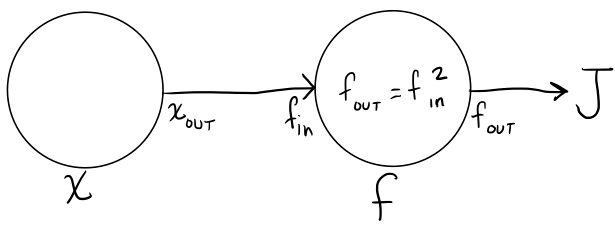

In [5]:
Image("images/comp-graph-xSquared.png")

Note that $f_{in}$ and $x_{out}$ are always equal in this graph, so you may be wondering why we give two separate names. In more complicated graphs (such as our next example), $x_{out}$ may serve as input to multiple nodes, ande we will neeed to consider that happens when we change $f_{in}$ independently of the oter node inputs connected to $x_{out}$. 

To represent this computation graph in code, we will use two nodes. The first node will be the same ValueNode x defined abobe. For the second node, f, we will create a new node type for the squaring computation. The code is as follows:

In [6]:
class SquareNode(object):
    """Node for squaring a scalar"""
    def __init__(self, x, node_name):
        """
         Parameters:
        :param x: a node producing a scalar as a numpy array
        :param node_name: node's name (string)
        """
        self.node_name = node_name
        self.out = None
        self.d_out = None
        self.x = x # Store a reference to node providing input to this node
        
    def forward(self):
        self.out = self.x.out ** 2
        self.d_out = np.zeros(self.out.shape)
        return self.out
    
    def backward(self):
        # Preconditions: self.d_out contains the partial derivatives of the graph output w.r.t. self.out
        d_x = self.d_out*2*self.x.out
        self.x.d_out += d_x
        return self.d_out
    
    def get_predecessors(self):
        """Get ist of node's predecessors"""
        return [self.x]
            
            

Note that in the `SquareNode` object `f`, the instance variables `self.x` and `self.out` correspond to $f_\text{in}$ and $f_\text{out}$, respectively, while `self.d_out` corresponds to $\frac{\partial J}{\partial f_\text{out}}$.

Let's walk through the code for `backward`.  First, before `backward` is called, we assume that `self.d_out` contains the value $\frac{\partial J}{\partial f_\text{out}}$.  In the first line of code of `backward`, we are doing the following computation:

$$
\frac{\partial J}{\partial f_\text{in}} = \left(\frac{\partial J}{\partial f_\text{out}}\right)\left(\frac{\partial f_\text{out}}{\partial f_\text{in}}\right)\\ = \left(\mathtt{self.d\_out}\right)\left(2 \cdot \mathtt{self.x.out} \right)
$$

We store the resulting value in `d_x`.  Next, we increment `self.x.d_out` so that value will contain $\frac{\partial{J}}{\partial{\mathtt{x_{out}}}}$.   In this particular situation, we could also have just set `self.x.d_out = d_x`, but in cases that the node `self.x` serves as input to multiple nodes, recall that we must add up gradient contributions from all of its children.  We'll revisit this when we get to a more complicated example.

Let's now construct the computation graph and evaluate it for a particular input value.  To do this, we construct the `ValueNode` `x`, which will contain our function input, and then `SquareNode` `f`, which gets a reference to `ValueNode` `x`, which essentially "connects" the nodes.  To evaluate the graph for a particular value, we first directly set the `out` field of the `ValueNode` `x`.  Then we call `forward` on `x` and then `f`.  After this "forward pass", the `out` variable in `f`, the graph output node, will contain the graph output.


In [7]:
# Construct the computation graph
x = ValueNode("x") # a graph input node
f = SquareNode(x, "Squaring Node")  #graph output node
# Set the input value
x.out = np.array(7) 
# Compute a forward pass
x.forward() 
f.forward() # returns the graph output

49

To run backpropagation, we start, as always, by setting `d_out` for the graph output node to be the scalar `1`.  Then we run `backward` on each node in a reverse topological order (i.e. children before parents). 

In [8]:
f.d_out = np.array(1)
f.backward()
x.backward()

array(14.)

### Gradient descent with a computation graph

In [9]:
obj_vals = []
x_vals = []
num_steps = 15
step_size = 0.3
x.out = np.array(3) # x = [3]
for step_num in range(num_steps):
    x_vals.append(x.out) # save input values at each step
    # forward pass
    x.forward()
    J = f.forward() # objective function value ("graph output")
    print("x =", x.out, "J(x) =",J)
    obj_vals.append(J) # save objective value at each step
    # Backward pass
    f.d_out = np.array(1) #initialize backpropagation
    f.backward()
    x_grad = x.backward() # save gradient with respect to x
    # take gradient step
    x.out =x.out - step_size*x_grad #gradient descend algorithm

x = 3 J(x) = 9
x = 1.2000000000000002 J(x) = 1.4400000000000004
x = 0.4800000000000001 J(x) = 0.23040000000000008
x = 0.19200000000000006 J(x) = 0.03686400000000002
x = 0.07680000000000003 J(x) = 0.005898240000000005
x = 0.030720000000000018 J(x) = 0.0009437184000000011
x = 0.012288000000000007 J(x) = 0.00015099494400000018
x = 0.004915200000000003 J(x) = 2.4159191040000033e-05
x = 0.0019660800000000016 J(x) = 3.865470566400006e-06
x = 0.0007864320000000008 J(x) = 6.184752906240012e-07
x = 0.0003145728000000003 J(x) = 9.89560464998402e-08
x = 0.00012582912000000013 J(x) = 1.5832967439974433e-08
x = 5.0331648000000057e-05 J(x) = 2.5332747903959096e-09
x = 2.0132659200000023e-05 J(x) = 4.0532396646334556e-10
x = 8.05306368000001e-06 J(x) = 6.48518346341353e-11


## A Computation Graph with Shared Input

Now we'll move on to a somewhat more complicated function: $J(x)=x^2e^x$.  This function is simple enough that we can calculate its derivative directly.  But in the spirit of computation graphs, we'll represent this function by a series of function compositions, which we'll then write as a computation graph.  We'll let

$$

f(x)  =  x^{2}\\
g(x)  =  e^{x}\\
h(x,y)  =  xy\\
J(x)  =  h(f(x),g(x))

$$

We'll write this as a computation graph with a `ValueNode` for $x$, and regular computation nodes for the functions $f$, $g$, and $h$:

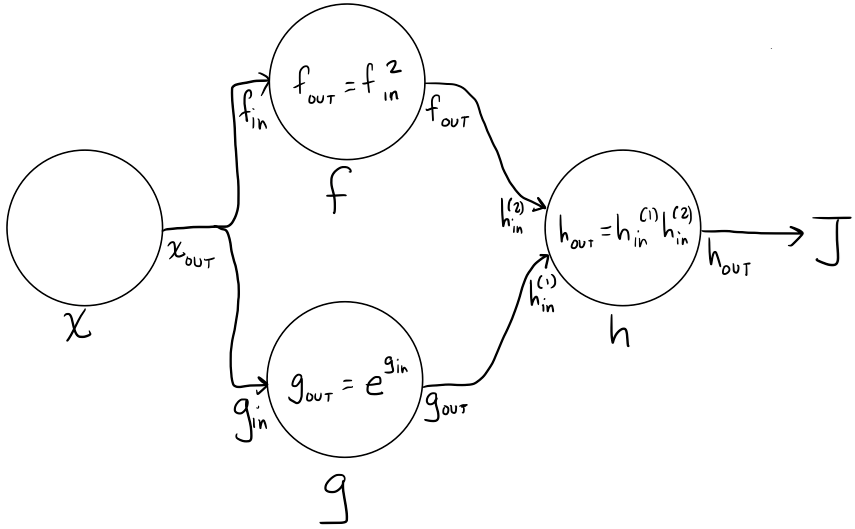

In [10]:
Image("images/sharedinput.png")

Note that nodes `f` and `g` share the input from node `x`.  Being able to handle this stucture is essential for coding more advanced neural network structures, such as convolutional neural networks and recurrent neural networks, though one can avoid it for standard multilayer perceptrons.

To implement this computation graph, we need two more node types, which we'll define now and walk through later:

In [11]:
class ExpNode(object):
    """Node for computing e^x for a scalar x"""
    def __init__(self, x, node_name):
        """
        parameters:
        :param x: a node producing a scalar
        :param node_name: node's name (a string) 
        """
        self.node_name = node_name
        self.out = None
        self.d_out = None
        self.x = x # store a reference to node providing input to this node
    def forward(self):
        self.out = np.exp(self.x.out) # compute and set the node output
        self.d_out = np.zeros(self.out.shape)
        return self.out
    
    def backward(self):
        # Preconditions:
        # self.out contains the output value of the node, namely e^(x.out)
        # self.d_out contains the partial derivatives of the graph output with respect to self.out
        d_x = self.d_out*self.out # partial of graph output with respect to node input x
        self.x.d_out += d_x
        return self.d_out
    
    def get_predecessors(self):
        """Get list of node's predecessors"""
        return [self.x]
        

In [12]:
class ProductNode(object):
    """Node for computing the product of two scalars"""
    def __init__(self, x, y, node_name):
        """
        parameters:
        :param x: a node producing a length-1 vector
        :param node_name: node's name (a string)
        """
        self.node_name = node_name
        self.out = None
        self.d_out = None
        self.x = x # store a reference to node providing input to this node
        self.y = y # store a reference to node providing input to this node
        
    def forward(self):
        self.out = self.x.out * self.y.out # compute and set the node output
        self.d_out = np.zeros(self.out.shape)
        return self.out
    
    def backward(self):
        # preconditions: self.d_out contains the partial derivatives of the graph output with respect to self.out
        d_x = self.d_out*self.y.out #partial of graph output with respect to node input x
        d_y = self.d_out*self.x.out
        self.x.d_out += d_x
        self.y.d_out += d_y
        return self.d_out
    
    def get_predecessors(self):
        """Get ist of node's predecessors"""
        return [self.x, self.y]
        
    

Define the computation graph and start a forward pass

In [13]:
x = ValueNode("x")
f = SquareNode(x, "Squaring Node")
g = ExpNode(x, "Exponentiation Node")
h = ProductNode(f, g, "Product Node")

x.out = np.array(7) # x.out = 7
# forward pass
x.forward()
f.forward()
g.forward()
h.forward()

print("x =", x.out)
print("f(x) = x^2 =", f.out)
print("g(x) = e^x =", g.out)
print("J = h(f(x), g(x)) = x^2*e^x =", h.out)

x = 7
f(x) = x^2 = 49
g(x) = e^x = 1096.6331584284585
J = h(f(x), g(x)) = x^2*e^x = 53735.024762994464


In a backward pass, we compute the partial derivative of the graph output $J$ with respect to the output of every node.  We'll illustrate how the backward pass works by showing the calculations we would do by hand, and where in the code the corresponding computation is carried out.  

We start out with $\frac{\partial J}{\partial h_\text{out}}=1$, which we set directly as the initialization of our backward pass:

In [14]:
h.d_out = np.array(1) #initialize backpropagation

Working backwards, we now want to compute $\frac{\partial J}{\partial h_{\text{in}}^{(1)}}$ and $\frac{\partial J}{\partial h_{\text{in}}^{(2)}}$ By the chain rule, we have
$$

\frac{\partial J}{\partial h_{\text{in}}^{(1)}} = \left(\frac{\partial J}{\partial h_{\text{out}}}\right)\left(\frac{\partial h_{\text{out}}}{\partial h_{\text{in}}^{(1)}}\right)\\ = \left(\frac{\partial J}{\partial h_{\text{out}}}\right)h_{\text{in}}^{(2)}.

$$

This is computed when we call `h.backward()`, specifically in the line `d_y = np.multiply(self.d_out, self.x.out)` of the `backward` method in `ProductNode`. `self.d_out` corresponds to $\frac{\partial J}{\partial h_{\text{out}}}$, which is $1$ in our case, and `self.x.out` is the input corresponding to $h_{\text{in}}^{(2)}$.  To see the correspondence between `x` and $h_{\text{in}}^{(2)}$ and between `y` and $h_{\text{in}}^{(1)}$, you need to look at the construction `h = ProductNode(f, g, "Product Node")` and the signature `__init__(self, x, y, node_name)` in `ProductNode`, and also cross-reference with the computation graph diagram.

Similarly
$$

\frac{\partial J}{\partial h_{\text{in}}^{(2)}} = \left(\frac{\partial J}{\partial h_{\text{out}}}\right)h_{\text{in}}^{(1)} 

$$
is implemented in `d_x = np.multiply(self.d_out, self.y.out)`.

Next let's compute the partials w.r.t. the output of $f$.  We have
$$\frac{\partial J}{\partial f_{\text{out }}}=\left(\frac{\partial J}{\partial h_{\text{in}}^{(2)}}\right)\underbrace{\left(\frac{\partial h_{\text{in}}^{(2)}}{\partial f_{\text{out}}}\right)}_{=1}= \frac{\partial J}{\partial h_{\text{in}}^{(2)}}
$$
We set this partial derivative in the code `self.x.d_out += d_x`, also in the `backward` method in `ProductNode`.  Recall that `x` is the local name for the node `f`.  Since `f.d_out` is initialized to `0`, this line of code is equivalent to setting `f.d_out = d_x`.  

Similarly, 
$$\frac{\partial J}{\partial g_{\text{out }}}=\left(\frac{\partial J}{\partial h_{\text{in}}^{(1)}}\right)\underbrace{\left(\frac{\partial h_{\text{in}}^{(1)}}{\partial g_{\text{out}}}\right)}_{=1}=\frac{\partial J}{\partial h_{\text{in}}^{(1)}},
$$
is implemented in the line `self.y.d_out += d_y`. 

We'll now continue the backward pass on $h$ and show how to check the outcome numerically:

In [15]:
h.backward()
# Save some values for later
f_x = f.out  # store output of f(x) for later
g_x = g.out  # store output of g(x) for later
J = h.out # store J(f(x),g(x))
dJdf = f.d_out
dJdg = g.d_out
print("At x=",x.out," we have f(x)=",f_x,", g(x)=",g_x,", h(x)=",J)
print("At those values, we have: ")
print("dJ/d[f(x)] =",dJdf)
print("dJ/d[g(x)] =", dJdg)

At x= 7  we have f(x)= 49 , g(x)= 1096.6331584284585 , h(x)= 53735.024762994464
At those values, we have: 
dJ/d[f(x)] = 1096.6331584284585
dJ/d[g(x)] = 49.0


### Numerically checking the gradient

By definition of gradient, this means that if we change the value of $f(x)$ by a small value $\delta$, with everything else held fixed, then we would expect the graph output $J$ to change by approximately $\delta \frac{\partial J}{\partial f(x)}$.  We can check this directly by  manipulating `f.out` and seeing the effect on the graph output `J=h.out`:

In [16]:
delta = np.random.randn()/100000  #choose a random perturbation (we can rerun this several times)
J_first_order_change_f = np.dot(delta, dJdf) #predicted change using derivative with respect to f
f.out = f_x + delta # change f.out by delta
h.forward() # compute J_new=h(f(x)+delta, g(x))
J_new = h.out
J_actual_change_f = J_new - J
print("For delta=",delta,", J(f(x)+delta, g(x)) - J(f(x),g(x)) = ", J_new - J)
print("First order prediction of J(f(x)+delta, g(x)) - J(f(x),g(x)) = ", J_first_order_change_f)

For delta= 5.836648706264947e-06 , J(f(x)+delta, g(x)) - J(f(x),g(x)) =  0.00640066250343807
First order prediction of J(f(x)+delta, g(x)) - J(f(x),g(x)) =  0.006400662505388705


In [17]:
delta = np.random.randn()/100000  #choose a random perturbation (we can rerun this several times)
J_first_order_change_g = np.dot(delta, dJdg) #predicted change using derivative with respect to g
g.out = g_x + delta # change g.out by delta
h.forward() # compute J_new=h(f(x), g(x)+delta)
J_new = h.out
J_actual_change_g = J_new - J
print("For delta=",delta,", J(f(x), g(x)+delta) - J(f(x),g(x)) = ", J_new - J)
print("First order prediction of J(f(x), g(x)+delta) - J(f(x),g(x)) = ", J_first_order_change_g)

For delta= 1.7283610737009153e-05 , J(f(x), g(x)+delta) - J(f(x),g(x)) =  0.007247559529787395
First order prediction of J(f(x), g(x)+delta) - J(f(x),g(x)) =  0.0008468969261134485


So we see a close match.  In fact, $J$ changes linearly with $f(x)$, when everything else is held fixed.  So  only numerical error is keeping the two numbers from being exactly equal. In the other way, $J$ changes exponentially with $g(x)$ when everything else is held fixed. And the error is two grades of magnitude greater. 

### Back to complete the backpropagation analysis

Next let's  compute $\frac{\partial J}{\partial f_{in}}$.  By the chain rule,
$$

\frac{\partial J}{\partial f_{\text{in}}}  =  \left(\frac{\partial J}{\partial f_{\text{out}}}\right)\left(\frac{\partial f_{\text{out}}}{\partial f_{\text{in}}}\right)\\
  =  \left(\frac{\partial J}{\partial f_{\text{out}}}\right)\left(2f_{\text{in}}\right)

$$
The pattern should start to be clear: The partial of $J$ w.r.t. the input of a node is the partial w.r.t. the output or a node (which we will already have computed) times the derivative of the function the node is calculating, i.e. $\frac{\partial f_{\text{out}}}{\partial f_{\text{in}}}$.

The above will be computed when we call `f.backward()`, specifically in the code `d_x = np.multiply(self.d_out, 2 * self.x.out)` in `backward()` of `SquareNode`.

It's much the same for $\frac{\partial J}{\partial g_{\text{in}}}$:
$$

\frac{\partial J}{\partial g_{\text{in}}}  =  \left(\frac{\partial J}{\partial g_{\text{out}}}\right)\left(\frac{\partial g_{\text{out}}}{\partial g_{\text{in}}}\right)\\
  = \left(\frac{\partial J}{\partial g_{\text{out}}}\right)e^{g_{\text{in}}}\\
  = \left(\frac{\partial J}{\partial g_{\text{out}}}\right)g_{\text{out}}

$$

One interesting thing that happens here is that, in the last line we notice that the derivative of the node function $e^{g_\text{in}}$ has already been computed and stored, since it's just the output value of the node.  This is a fairly common occurrence and is worth noting: computations that happen during the forward pass are often needed again during the backward pass, so it is worth caching these values in the forward pass so they can be used without recomputation in the backward pass.  In this case, `self.out` happens to be the factor we need in the backward pass. The computation above happens when we call `g.backward()`, specifically in the code `d_x = np.multiply(self.d_out, self.out)` in `backward()` of `SquareNode`.

Let's re-run the forward pass from scratch, and then run the backward pass through to `f` and `g`, and pick up the discussion from there.

In [18]:
x.out = np.array(7) #Set the value of the input node
# Forward pass -- call forward() on nodes in topological order (parents before children)
x.forward()
f.forward()  
g.forward()
h.forward()
# Backward pass -- call backward() on nodes in reverse topological order (children before parents)
h.d_out = np.array(1) #initialize backpropagation
h.backward() 
f.backward()
g.backward()


array(49.)

## Handling the shared input

We've finally to the last, and most interesting, step of backpropagation.  As usual, we use the chain rule, although this time we have two paths between input and output to sum over:
$$

\frac{\partial J}{\partial x_{\text{out}}} = \frac{\partial J}{\partial f_{\text{in}}}\underbrace{\frac{\partial f_{\text{in}}}{\partial x_{\text{out}}}}_{=1}+\frac{\partial J}{\partial g_{\text{in}}}\underbrace{\frac{\partial g_{\text{in}}}{\partial x_{\text{out}}}}_{=1}\\
 =  \frac{\partial J}{\partial f_{\text{in}}}+\frac{\partial J}{\partial g_{\text{in}}}

$$
So this is, of course, the sum of two things we have already computed.  The way this happens in code is as follows: During the forwared pass, `x.d_out` is initialized to `0`.  When we call `f.backward()`, the line `self.x.d_out += d_x` in the `SquareNode` class adds $\frac{\partial J}{\partial f_\text{in}}$, to `x.d_out`. When we call `g.backward()`, the same line `self.x.d_out += d_x` in the `ExpNode` class adds $\frac{\partial J}{\partial g_\text{in}}$ to `x.d_out`.  Thus after calling backward on `f` and `g`, `x.d_out` indeed has the value $\frac{\partial J}{\partial x_{\text{out}}}$.  By the time we get to run `backward` on `x`, there's nothing left to do.  Indeed, `x.backward()` just returns `self.d_out`.

## Automating the forward and bakcward passes

In the demonstrations above, we called the forward and backward functions on each node manually, and in the correct order. While this helps ensure one understands all the details, it can easily be automated. The key is that each node can return a list of its parent nodes through the `get predecesors` method. Given the graph output node, we can collect all the ancestors and, moreover, produce a list of these nodes in a topological ordering (each parent coming before its children). The following function does exactly that. The graph output node is referred to as the sink node in this context.

In [19]:
def sort_topological(sink):
    """Returns a list of the sink node and all its ancestors in a topologically sorted order.
    Subgraph of these nodes must form a DAG"""
    L = [] # empty list that will contain the sorted nodes
    T = set() # set of empty temporarily marked nodes
    P = set() # set of permanently marked nodes
    
    def visit(node):
        if node in P:
            return
        if node in T:
            raise 'Your graph is not a DAG'
        T.add(node) # mark node temporarily
        for predecessor in node.get_predecessors():
            visit(predecessor)
        P.add(node) # mark node permanently
        L.append(node)
        
    visit(sink)
    return L

In [24]:
for node in sort_topological(h):
    print(node.node_name, ":  ", node)

x :   <__main__.ValueNode object at 0x0000020E6EE5DEB0>
Squaring Node :   <__main__.SquareNode object at 0x0000020E7E5AD190>
Exponentiation Node :   <__main__.ExpNode object at 0x0000020E7E393380>
Product Node :   <__main__.ProductNode object at 0x0000020E700D8590>
